In [116]:
!pip3 install tensorflow
!pip3 install tensorflow-addons

     |████████████████████████████████| 575 kB 4.1 MB/s eta 0:00:01


### INTRODUCTION

Learning from past data is historically ill-posed. A machine learning model may fit past data well, but may perform poorly on new data. No where is this more true than in the financial markets. Investors want to have a good idea where a stock price is headed before making any investment decisions.

### PROBLEM STATEMENT:
In this notebook, we aim to produce reliable time-series forecasting of stock prices by using Recurrent Neural Networks. More specifically, we aim to use the Long Short-Term Memory (LSTM) architecture to accomplish better stock price forecasting.

### PROBLEM TYPE:
The type of problem we are trying to solve is a deep learning problem. We are using Recurrent Neural Networks with LSTM architecture to predict the price of a stock based on a set of features. Our features used to train our model are the open price, close price, low price, high price, and trading volume of a single stock. We construct the model using a **ModelWrapper class**, which uses the Keras module inside its build method. Furthermore, we use MSE for the loss function, adam for the optimizer, and accuracy for model evaluation.


### HYPOTHESIS:
We hypothesize that reliable stock price forecasting can be made using features sych as the open price, close price, overall day high price, overall day low price, and volume of trading on a given stock.

In [408]:
import numpy as np
import pandas as pd
import math
import datetime
import os
import sklearn
import sklearn.preprocessing
import tensorflow as tf

#Read data from CSV and transform into pandas
path = 'data/prices-split-adjusted.csv'
df = pd.read_csv(path)

#Inspect data
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


### METHODOLOGY: 
 
In this notebook, we process the raw data from the csv file into a pandas dataframe and proceed to **normalize** the numerical values of each feature we are interested in. Further processing of the data includes dropping the symbols column and the date column before constructing our train/test sets.

#### INPUT DATA
Our input data will be a csv file obtained from kaggle [1], which we turn into a pandas dataframe (df). Each row in df has the columns of date, symbol, open, close, high, low, and volume. The middle four columns represent the stock price for a particular day and the last column represents the trading volume for that particular day. The model is trained on windows of these rows, where each window represents x number of rows with all five columns included. In order to improve the reliability of stock forecasting, a model is built and trained on a single stock symbol (i.e. "AMZN"). Fetching and processing the input data is done inside the **StockData class**.

In the second phase of this project, we train and fit the model using X_train, y_train, X_test, y_test, respectively. The training/test/validation data is data derived from **Data.load_model(stock)** method of the **StockData class**. Furthermore, our **chosen measure of success is accuracy**, which is the rate of correct predictions. High accuracy on validation data is how we have defined reliable forecasting. A validation set is our chosen evaluation protocol and we are looking for lower MSE on Validation scores. The following is the methodology followed in this notebook:

1. PREPARING DATA:
    - StockData Class
    - Get Data for one stock
    - Normalize data
    - Get model Train/Test data
4. BUILDING A MODEL THAT DOES BETTER THAN A VALIDATION RMSE OF 0.5
    - ModelWrapper class
    - Setting hyperparameters
5. TRAIN/FIT MODEL
6. TESTING THE MODEL ON X_TEST
7. EVALUATING THE MODEL
    - Train score and test score
    - Hold out validation set
8. SCALING UP: DEVELOPING A MODEL THAT OVERFITS
    - Hyperparameter tunning and regularization
    - Train and fit new model
    - Evaluate new model





### PREPARING DATA: 
We implemented a **StockData class** that is capable of retrieving data for a single stock using the get_stock method. Moreover, the class has the normalize and denormalize functionality that is necessary to process our data and then later interpret.

In [462]:
class StockData(object):
    
    def __init__(self, path):
        ''' Holds data frame'''
        
        self.df = pd.read_csv(path)
        
        if self.df.empty:
            raise ErrorInvalidCSV("Invalid file passed ")
            
        self.current_symbol = None
        
            
            
    #normalize
    def normalize(self,df):
        '''Normalizes data for a single stock'''
        
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Invalid df passed as argument: {}".format(type(df)))
            
        MMScaler = sklearn.preprocessing.MinMaxScaler()
        df['open'] = MMScaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = MMScaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = MMScaler.fit_transform(df.low.values.reshape(-1,1))
        df['volume'] = MMScaler.fit_transform(df.volume.values.reshape(-1,1))
        df['close'] = MMScaler.fit_transform(df['close'].values.reshape(-1,1))
        return df
    
    #denormalize
    def denormalize(self, df, values_normal):
        '''Denormalize values coming from Model Predictions'''
        
        df = df['close'].values.reshape(-1,1)
        values_normal = values_normal.reshape(-1,1)

        #return df.shape, p.shape
        MMScaler = sklearn.preprocessing.MinMaxScaler()
        a = MMScaler.fit_transform(df)
        denormalized = MMScaler.inverse_transform(values_normal)
        
        return denormalized
    
    #load
    def load_model_data(self, stock):

        try:
            stock.values
        except:
            raise ErrorInvalidStockObject("Stock must be a dataframe object with the values attribute")
    
        
        seq_len = self.window + 1
        features = stock.columns
        data = stock.values
        result = []

        for i in range(len(data) - seq_len): 
            result.append(data[i: i + seq_len]) # index : index + [window]days

        result = np.array(result)
        
        row = int(round((1-vs) * result.shape[0])) 
        train = result[:row, :]  

        x_train = train[:, :-1] 
        y_train = train[:, -1][:,-1]
        
        end = int(round((1-(vs/2)) * result.shape[0])) 

        x_test = result[row:end, :-1] 
        y_test = result[row:end, -1][:,-1]
        
        x_valid = result[end:, :-1] 
        y_valid = result[end:, -1][:,-1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))
        x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], len(features)))
        
        return {
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test,
            'y_test': y_test, 
            'x_valid': x_valid,
            'y_valid': y_valid,
            'window': seq_len -1,
            'n_features': len(features)
            
        }
    

    def get_stock(self, symbol, parameters):
        '''Gets single stock data from pd'''
        
        stock = self.df[self.df.symbol == symbol].copy()

        if stock.empty:
            raise SymbolNotFoundError("The inputed symbol was not found in the data")
        
        #attach symbol
        self.current_symbol = symbol
            
        if "window" not in parameters:
            raise InvalidParameters("No window was supplied to get_stock")
        
        self.window = parameters["window"]
            
        if "validation_split" not in parameters:
            raise InvalidParameters("No validation_split was supplied to get_stock")
        
        vs = parameters["validation_split"] 
        
        if vs > 0.9 or vs < 0.1:
            raise InvalidParameters("validation_split must be between 0.1 and 0.9")
            
        self.vs = vs
        
        ##drop columns not needed for training
        stock.drop(['symbol'],1,inplace=True)
        
        ##Move close to the end
        stock["mov_close"] = df.close 
        stock.drop(['close'], 1, inplace=True) 
        stock["close"] = stock.mov_close # Moving close to the last column
        stock.drop(['mov_close'], 1, inplace=True) 
        

        
            
        return stock.copy()

        
        
    def __repr__(self):
        return ('<StockData load_stock="{}", plot_stock={}>'
                .format(self.load_stock, self.plot_stock))
    
    def __str__(self):
        return self.__repr__()
    
class ErrorInvalidCSV(Exception):
    pass

class SymbolNotFoundError(Exception):
    pass

class NoCurrentStockError(Exception):
    pass  

### GET DATA FOR ONE STOCK:

We hypothesize that are models will be most accurate if we have a single model trained on data for a single stock. Different stocks behave differently on the financial markets and we would not want to train the model on every single stock. In order to do this, we need to separate the data for one stock from the rest of the dataframe columns. This is done by using **Data.get_stock(SYMBOL, Params)**.

In [463]:
StockDataParameters = {
    "window": 22,
    "validation_split": 0.2
}


Data = StockData('data/prices-split-adjusted.csv')

#stock data not normalized
stock_data = Data.get_stock("AMZN", StockDataParameters)
print(stock_data)

              date        open         low        high      volume       close
284     2010-01-04  136.250000  133.139999  136.610001   7599900.0  133.899994
751     2010-01-05  133.429993  131.809998  135.479996   8851900.0  134.690002
1219    2010-01-06  134.600006  131.649994  134.729996   7178800.0  132.250000
1687    2010-01-07  132.009995  128.800003  132.320007  11030200.0  130.000000
2155    2010-01-08  130.559998  129.029999  133.679993   9830500.0  133.520004
...            ...         ...         ...         ...         ...         ...
848799  2016-12-23  764.549988  757.989990  766.500000   1976900.0  760.590027
849299  2016-12-27  763.400024  761.200012  774.650024   2627400.0  771.400024
849799  2016-12-28  776.250000  770.500000  780.000000   3279100.0  772.130005
850299  2016-12-29  772.400024  760.849976  773.400024   3153500.0  765.150024
850799  2016-12-30  766.469971  748.280029  767.400024   4125300.0  749.869995

[1762 rows x 6 columns]


### NORMALIZE DATA

In [464]:
#normalize stock data
stock_data_norm = Data.normalize(stock_data)

## print 1 window 
print(stock_data_norm[0:StockDataParameters["window"]])

#remove date from df
dates = stock_data_norm.date
stock_data_norm.drop(['date'], 1, inplace=True)

             date      open       low      high    volume     close
284    2010-01-04  0.040981  0.037207  0.034406  0.159653  0.034373
751    2010-01-05  0.037169  0.035397  0.032870  0.189868  0.035447
1219   2010-01-06  0.038751  0.035180  0.031851  0.149491  0.032130
1687   2010-01-07  0.035250  0.031301  0.028576  0.242437  0.029072
2155   2010-01-08  0.033290  0.031614  0.030424  0.213485  0.033857
2623   2010-01-11  0.036074  0.031859  0.029229  0.188118  0.029494
3091   2010-01-12  0.031168  0.028239  0.025179  0.195766  0.025471
3559   2010-01-13  0.029695  0.027150  0.025030  0.235028  0.027863
4027   2010-01-14  0.031371  0.028035  0.025940  0.212143  0.025471
4495   2010-01-15  0.031425  0.028933  0.024948  0.347327  0.025185
4963   2010-01-19  0.027546  0.025218  0.022706  0.190850  0.025824
5431   2010-01-20  0.028654  0.026238  0.024337  0.195245  0.023337
5899   2010-01-21  0.028830  0.026130  0.022910  0.216866  0.024478
6367   2010-01-22  0.026586  0.020359  0.022258 

### GET MODEL TRAIN/TEST DATA

In [465]:
##Get training data
model_data = Data.load_model_data(stock_data_norm)

X_train, y_train = model_data["x_train"], model_data["y_train"]
X_test, y_test = model_data["x_test"], model_data["y_test"]
X_valid, y_valid = model_data["x_valid"], model_data["y_valid"]

##number of features and sequence length (window)
n_features = model_data["n_features"]
seq_len = model_data["window"]

#print X_test, y_test
print("Number of features: ", n_features)
print("Window = ", X_test[0], "\n y-value = " ,y_test[0], "\n")
print("Window = ", X_valid[0], "\n y-value = " ,y_valid[0], "\n")

Number of features:  5
Window =  [[0.48267242 0.48230814 0.48022883 0.04833879 0.4792117 ]
 [0.48599737 0.48856832 0.49542069 0.0750832  0.49863407]
 [0.50248699 0.50551172 0.50838407 0.09527303 0.50886852]
 [0.52258538 0.51660316 0.51895586 0.0909363  0.51578663]
 [0.51627336 0.51272455 0.51308565 0.05303028 0.51565071]
 [0.51369178 0.51592271 0.51800466 0.05141577 0.51601766]
 [0.52135541 0.50340232 0.51686324 0.20247751 0.5077404 ]
 [0.63939124 0.57641534 0.637678   0.50498712 0.57194698]
 [0.57013491 0.57267282 0.58927601 0.15702505 0.57465169]
 [0.58128567 0.56793686 0.57764431 0.10350004 0.5673395 ]
 [0.57441948 0.57052264 0.57299701 0.06680551 0.57137616]
 [0.56999978 0.56952911 0.58146266 0.06657625 0.58192323]
 [0.58546217 0.58345132 0.58640887 0.04926068 0.58109417]
 [0.58324551 0.57642896 0.58314761 0.04898556 0.57957192]
 [0.57275703 0.57615676 0.57840526 0.04706456 0.57531775]
 [0.58507015 0.58290692 0.58138113 0.04597374 0.58226302]
 [0.58574595 0.57392492 0.58627293 0.06

### ModelWrapper Class:

This class takes in model parameters such as decay and dropout, and builds an RNN with LSTM architecture using Keras inside its build method.

In [475]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import datetime
import math, time
import keras

class InvalidStockObject(Exception):
    pass

class InvalidParameters(Exception):
    pass


class ModelWrapper(object):
    
    def __init__(self, stock, parameters):
        '''Initializes model parameters'''
        
        if "dropout" not in parameters:
            raise InvalidParameters("No dropout was supplied to ModelWrapper")
        
        if "decay" not in parameters:
            raise InvalidParameters("No decay was supplied to ModelWrapper")
            
            
        self.dropout = parameters["dropout"]
        self.decay = parameters["decay"]
   

    def build(self,layers, dense_layers= 16, lstm_layers= 128):
        '''Function builds the model'''
        model = Sequential()

        model.add(LSTM(lstm_layers, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(self.dropout))

        model.add(LSTM(lstm_layers, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(self.dropout))

        model.add(Dense(dense_layers,kernel_initializer="uniform",activation='relu'))        
        model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

        adam = keras.optimizers.Adam(decay=self.decay)

        start = time.time()
        model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
        print("Compilation Time : ", time.time() - start)
        return model



        
    def __repr__(self):
        return ('<Model epoch_index="{}", permutations={}, seq_len="{}">'.format(self.epoch_index, self.permuations, self.seq_len))
    def __str__(self):
        return self.__repr__()

### BUILDING A MODEL THAT DOES BETTER THAN A VALIDATION RMSE OF 0.5:
Our **baseline will be a validation score accuracy RMSE of 0.5.** RMSE values below 0.5 are considered to achieve statistical power. 

#### Setting hyperparameters:
Set dropout and decay parameters inside the ModelParameters. We can keep tuning these parameters to get the best possible results.

In [476]:
#Model specific parameters
ModelParameters = {
    "dropout": 0.1,
    "decay" : 0.6
}

model = ModelWrapper(stock, ModelParameters)
model = model.build([n_features,seq_len,1])

Compilation Time :  0.028588056564331055


### TRAIN AND FIT MODEL:

Set ModelTrainParameters of batch_size and epochs and get validation_split from StockData. From previous trials, we have discovered that 90 epochs with a batch_size of 512 gives a good model that generalizes well.

In [477]:
#Parameters of training
ModelTrainParameters = {
    "batch_size": 256,
    "epochs": 45
}

#fit the model
batch_size = ModelTrainParameters["batch_size"]
epochs = ModelTrainParameters["epochs"]
vs = StockDataParameters["validation_split"]

model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=vs,verbose=1)

Train on 1112 samples, validate on 279 samples
Epoch 1/45
1024/1112 [==========================>...] - ETA: 0s - loss: 0.0356 - acc: 9.7656e-04

/Users/alanjudi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1112/1112 [==============================] - 2s 2ms/sample - loss: 0.0357 - acc: 8.9928e-04 - val_loss: 0.1157 - val_acc: 0.0000e+00
Epoch 2/45
1112/1112 [==============================] - 0s 384us/sample - loss: 0.0248 - acc: 8.9928e-04 - val_loss: 0.0414 - val_acc: 0.0000e+00
Epoch 3/45
1112/1112 [==============================] - 0s 403us/sample - loss: 0.0088 - acc: 8.9928e-04 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 4/45
1112/1112 [==============================] - 0s 429us/sample - loss: 0.0057 - acc: 8.9928e-04 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 5/45
1112/1112 [==============================] - 0s 414us/sample - loss: 0.0057 - acc: 8.9928e-04 - val_loss: 0.0229 - val_acc: 0.0000e+00
Epoch 6/45
1112/1112 [==============================] - 0s 413us/sample - loss: 0.0026 - acc: 8.9928e-04 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 7/45
1112/1112 [==============================] - 0s 410us/sample - loss: 0.0012 - acc: 8.9928e-04 - val_loss: 0.0091 - val_acc: 0.

### TESTING THE MODEL ON X_TEST:

Predictions are derived from X_test using the model's predict method. These values are then denormalized and compared to actual values seen in the real data. 

In [478]:
predictions_normal_test = model.predict(X_test)

#Get current stock
symbol = Data.current_symbol
df_stock = Data.get_stock(symbol, StockDataParameters)
df_stock.drop(['date'], 1, inplace=True)

predictions_denorm_test = Data.denormalize(df_stock, predictions_normal_test)
y_test_denorm = Data.denormalize(df_stock, y_test)


##Print samples to ensure denormalization is working
samples = 5
print("Printing ", samples, "samples to compare.... \n")
for i in range(5):   
    print("Prediction: {}, Actual: {}".format(predictions_denorm_test[i], y_test_denorm[i]))

Printing  5 samples to compare.... 

Prediction: [454.0625], Actual: [531.52002]
Prediction: [454.88617], Actual: [535.219971]
Prediction: [455.6575], Actual: [535.02002]
Prediction: [456.4156], Actual: [532.919983]
Prediction: [457.05252], Actual: [515.780029]


### EVALUATING THE MODEL:  


#### TRAIN SCORE AND TEST SCORE

To evaluate the model, we use the Root Mean-square error for the train/test set, respectively. Values below 0.2 are considered fantastic, and if we are able get a better test score than training score, it means that our model would generalize well!!


TEST SET
Train Score: 0.00060 MSE (0.02 RMSE)
Test Score: 0.02767118267800616 MSE (0.16634657398938568 RMSE)


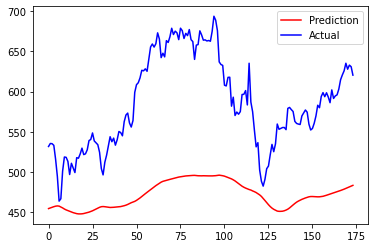

In [479]:
import matplotlib.pyplot as plt2

#Get current stock
symbol = Data.current_symbol
df_stock = Data.get_stock(symbol, StockDataParameters)
df_stock.drop(['date'], 1, inplace=True)


#test set
predictions_denorm_test = Data.denormalize(df_stock, predictions_normal_test)
y_test_denorm = Data.denormalize(df_stock, y_test)

def model_score(model, X, y, X_, y_, valid):
    trainScore = model.evaluate(X, y, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    
    testScore = model.evaluate(X_, y_, verbose=0)
    test_type = "Test"
    if valid:
        test_type = "Validation"  
                               
    print("{} Score: {} MSE ({} RMSE)".format(test_type, testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

def plot_score(model, X, y, X_, y_, pred, actual, valid):
    #Score for training score, Test score
    model_score(model, X, y, X_, y_, valid)
    plt2.plot(pred,color='red', label='Prediction')
    plt2.plot(actual,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.show()

#VALIDATION SET
print("TEST SET")
plot_score(model,X_train, y_train, X_test, y_test, predictions_denorm_test,y_test_denorm, valid= False)

#### HOLD OUT VALIDATION SET:

Our hold out validation set is y_valid, x_valid. We run accuracy measurenments on this hold out set as per our Model Evaluation protocol.

VALIDATION SET
Train Score: 0.00060 MSE (0.02 RMSE)
Validation Score: 0.1141667279532586 MSE (0.3378856729032153 RMSE)


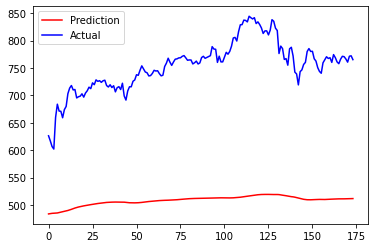

In [480]:
#VALIDATION SET
print("VALIDATION SET")
predictions_normal_valid = model.predict(X_valid)
df_stock_valid = Data.get_stock(symbol, StockDataParameters)
df_stock_valid.drop(['date'], 1, inplace=True)
predictions_denorm_valid = Data.denormalize(df_stock_valid, predictions_normal_valid)
y_valid_denorm = Data.denormalize(df_stock_valid, y_valid)

#Plot and score for validation set
plot_score(model,X_train, y_train, X_valid, y_valid, predictions_denorm_valid,y_valid_denorm, valid = True)

## SCALING UP: DEVELOPING A MODEL THAT OVERFITS

With a validation score accuracy RMSE of 0.337, we can say that our model does better than the baseline of 0.5. Generally speaking, we want a model that does not overfit our training data so that our model can better predict new unseen data, but we also want to fit our training data just enough to get higher validation scores. In this stage, we want to tune our hyperparameters to better fit our training data and achieve better generalization onto validation data.


### HYPERPARAMETER TUNING AND REGULARIZATION
We can change the number of layers inside the LSTM to 256 and the dense_layer to 32. Moreover, we can train for 90 epochs instead of 45 and increase our batch size to 512. Furthermore, we can increase the dropout to 0.3 from 0.1 and our decay down to 0.2 from 0.6.

In [482]:
#Model specific parameters
ModelParameters2 = {
    "dropout": 0.3,
    "decay" : 0.2
}

model2 = ModelWrapper(stock, ModelParameters2)
model2 = model2.build([n_features,seq_len,1], dense_layer= 32, lstm_layers=256)

Compilation Time :  0.02370309829711914


### TRAIN AND FIT NEW MODEL

In [483]:
#Parameters of training
ModelTrainParameters2 = {
    "batch_size": 256,
    "epochs": 45
}


batch_size2 = ModelTrainParameters2["batch_size"]
epochs2 = ModelTrainParameters2["epochs"]
vs = StockDataParameters["validation_split"]

## FIT AND TRAIN NEW MODEl
model2.fit(X_train,y_train,batch_size=batch_size2,epochs=epochs2,validation_split=vs,verbose=1)

Train on 1112 samples, validate on 279 samples
Epoch 1/45
1112/1112 [==============================] - ETA: 0s - loss: 0.0301 - acc: 8.9928e-04

/Users/alanjudi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1112/1112 [==============================] - 2s 2ms/sample - loss: 0.0301 - acc: 8.9928e-04 - val_loss: 0.0129 - val_acc: 0.0000e+00
Epoch 2/45
1112/1112 [==============================] - 1s 710us/sample - loss: 0.0080 - acc: 8.9928e-04 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 3/45
1112/1112 [==============================] - 1s 724us/sample - loss: 0.0076 - acc: 8.9928e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 4/45
1112/1112 [==============================] - 1s 734us/sample - loss: 0.0032 - acc: 8.9928e-04 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 5/45
1112/1112 [==============================] - 1s 734us/sample - loss: 0.0020 - acc: 8.9928e-04 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 6/45
1112/1112 [==============================] - 1s 748us/sample - loss: 0.0013 - acc: 8.9928e-04 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 7/45
1112/1112 [==============================] - 1s 742us/sample - loss: 0.0011 - acc: 8.9928e-04 - val_loss: 0.0066 - val_acc: 0.

### EVALUATE NEW MODEL

VALIDATION SET MODEL 2
Train Score: 0.00039 MSE (0.02 RMSE)
Validation Score: 0.0531572247801841 MSE (0.23055850619785015 RMSE)


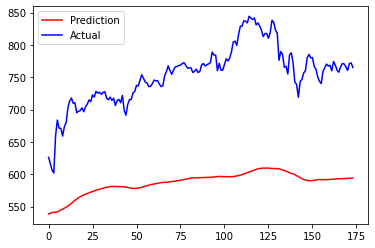

In [484]:
#VALIDATION SET
print("VALIDATION SET MODEL 2")
predictions_normal_valid = model2.predict(X_valid)
df_stock_valid = Data.get_stock(symbol, StockDataParameters)
df_stock_valid.drop(['date'], 1, inplace=True)
predictions_denorm_valid = Data.denormalize(df_stock_valid, predictions_normal_valid)
y_valid_denorm = Data.denormalize(df_stock_valid, y_valid)

#Plot and score for validation set
plot_score(model2,X_train, y_train, X_valid, y_valid, predictions_denorm_valid,y_valid_denorm, valid = True)

This time we got a RMSE of 0.23, which is much better than our original 0.337. 

## CONCULSION

The model as defined by our accuracy RMSE baseline of 0.5 on our validation set has clear statistical power. Due to this fact, we can accept the hypothesis that Recurrent Neural Network with LSTM architecuture can produce reliable stock forecasting when trained on 4-features of stock price and 1-feature of stock trading volume. We can achieve better results through hyperparameter tuning, but we must be careful not to overfit our model to our training data as that can lead to poor generalization. 

### REFERENCES

[1] https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru/data?select=prices-split-adjusted.csv